## Gaussian Grid

To get the parameters for the gaussian grid, it has to be visualised. The main reason for this is that $\sigma$, $\beta$, and n do not have any physical units. 

In addition to the point of interest (latitude, longitude), the following parameters have to be picked:
- $\phi_{ini}$: initial distance between grid points, in degrees
- $\phi_{max}$: maximum distance between grid points, in degrees
- $\sigma$: size of the denser part of the grid.
- $\beta$: slope of the increase in grid point distance.
- n: number of points in the variable. 

When a larger n is used, $\sigma$ also has to be increased. 

In [9]:
def Gauss_Grid(sigma,beta,phi_ini,phi_max,lat_0,lon_0,n,plot=True,Dense_Antipole = True):
    """
    This function creates a Gaussian grid. Input parameters:
    sigma (greater than 2) = standard deviation, i.e. size of the area of denser grid points
    beta = steepness of the drop of to the maximum distance
    phi_ini = initial distance between grid points, in degrees
    phi_max = maximum distance between grid points, in degrees
    lat_0 = latitude of point of interest
    lon_0 = longitude of point of interest
    n = number of circles
    plot = True/False
    Dense_Antipole = True/False
    """
    
    ### Error messages
    if lat_0 < -90 or lat_0 > 90:
        msg = 'lat_0 has to be between -90° and 90°'
        raise ValueError(msg)
    
    if lon_0 < -180 or lon_0 > 180:
        msg = 'lon_0 has to be between -180 and 180'
        raise ValueError(msg)
        
    if phi_ini > 90 or phi_max > 90:
        msg = 'phi_ini and phi_max should not be larger than 90'
        raise ValueError(msg)
    
    if phi_ini > phi_max:
        msg = 'phi_ini should be smaller than phi_max'
        raise ValueError(msg)
    
    # PHI IS LATITUDE BETWEEN -90 and 90
    # THETA IS LONGITUDE BETWEEN -180 and 180

    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    import warnings
    warnings.filterwarnings("ignore")

    # Step 1: Gauss
    # Calculate radii of the circles
    # How do we get n from this.
    phi_max = phi_max - phi_ini
    
    lat = np.linspace(0,90,n)
    dphi1 = phi_max*(1 - np.exp(-(lat/sigma)**beta))+phi_ini

    phi = []
    dphi = []
    phi_0 = 0
    
    if Dense_Antipole:
        for i in range(0,np.size(dphi1)):
            phi_0 += dphi1[i]
            phi.append(phi_0)
            dphi.append(dphi1[i])
            # Change condition so that if the distance between equator and previous circle is greater than that befor
            if phi_0 > 90:
                if dphi[i] > dphi[i-1]:
                    if 90-phi[i-1] < dphi[i-1]:
                        phi = phi[:-2]  # removes last entry of phi since it would be bigger than 90
                        dphi = dphi[:-2] # removes last phi
                        phi_0 = 90
                        phi.append(phi_0)
                        dphi.append(90-phi[i-2])
                        break
                    else:
                        phi = phi[:-1]  # removes last entry of phi since it would be bigger than 90
                        dphi = dphi[:-1] # removes last phi
                        break
                elif dphi[i] <= dphi[i-1]: 
                    if 90-phi[i-1] < dphi[i-1]:
                        phi = phi[:-2]  # removes last entry of phi since it would be bigger than 90
                        dphi = dphi[:-2] # removes last phi
                        phi_0 = 90
                        phi.append(phi_0)
                        dphi.append(90-phi[i-2])
                        break
                    else:
                        phi = phi[:-1]  # removes last entry of phi since it would be bigger than 90
                        dphi = dphi[:-1] # removes last phi
                        break       
                else:
                    phi = phi[:-1]  # removes last entry of phi since it would be bigger than 90
                    dphi = dphi[:-1] # removes last phi
                    #phi_0 = 90
                    #phi.append(phi_0)
                    #dphi.append(90-phi[i-2])
                    break
    else:
        for i in range(0,np.size(dphi1)):
            phi_0 += dphi1[i]
            phi.append(phi_0)
            dphi.append(dphi1[i])            
            if phi_0 > 180:
                phi = phi[:-1]  # removes last entry of phi since it would be bigger than 180
                dphi = dphi[:-1] # removes last phi
                break                

    # phi now consists of the latitudinal angles up to 90° over which we should loop

    # Step 2: Longitudinal angles (azmiuth)
    # We want these angles to be close to the latitudinal distance between the circles

    dtheta = dphi
    N = np.around(np.divide(360,dtheta))
    
    # To get the angle we now use 2*Pi/N
    theta = np.divide(2*np.pi,N)
    
    ## We now have the latitudes and the angle over which we have to loop to get the longitudes. 
    # Step 3: Loop

    lat_final1 = [0]
    lon_final1 = [0]
    

    for i in range(0,np.size(phi)-1):
        for j in range(0,int(N[i])):
            # first need to calculate all longitudes
            lon_final1.append(np.rad2deg(j*theta[i]))
            lat_final1.append(phi[i])
            
    # need to shift it
    lon_final1 = np.subtract(lon_final1,180)
    lat_final1 = np.subtract(lat_final1,90)
    
    
    if Dense_Antipole:
        # Now flip the longitude to make the other hemisphere
        lat_final2 = [0]
        lon_final2 = [0] 

        for i in range(0,np.size(phi)):    # size(phi) - 1 since we don't want two sets of points around the equator
            for j in range(0,int(N[i])):
                # first need to calculate all longitudes
                lon_final2.append(np.rad2deg(j*theta[i]))
                lat_final2.append(phi[i])

        # Shift coordinates and flip it
        lon_final2 = np.subtract(lon_final2,180)
        lat_final2 = np.subtract(lat_final2,90)
        lat_final2 = np.multiply(lat_final2,-1)
        lon_final2 = lon_final2

        # Combine the two
        lat_final = np.concatenate((lat_final1,lat_final2))
        lon_final = np.concatenate((lon_final1,lon_final2))
    else:
        lat_final = lat_final1
        lon_final = lon_final1
    
    # Calculate grid point distance of densest grid area in m for latitude
    dlat = 111132.954 - 559.822 * np.cos(2*lat_0) + 1.175*np.cos(4*lat_0)
    dx_min = dphi[0]*dlat
    dx_max = dphi[-1]*dlat
        
    print('Number of Gridpoints:',np.size(lat_final))
    print('Minimum dx in m:',np.around(dx_min,3),'m which is',np.around(dphi[0],3),'°')
    print('Maximum dx in m:',np.around(dx_max,3),'m which is',np.around(dphi[-1],3),'°')

    # ROTATION TO AREA OF INTEREST
    # We have the variables lon_final, lat_final
    # lat_0 and lon_0 give the point to which the center should be shifted in degrees

    # Step 1: Convert lat_final & lon_final from degrees to radians
    if Dense_Antipole:
        lat_final_rad = np.deg2rad(lat_final)
        lon_final_rad = np.deg2rad(lon_final)
    else:
        lat_final_rad = -np.deg2rad(lat_final)
        lon_final_rad = -np.deg2rad(lon_final)

    # Rotation around y-axis and z-axis
    theta_rot = np.deg2rad(90-lat_0)
    phi_rot = np.deg2rad(lon_0)

    # Convert grid from spherical to cartesian 
    x_cart = np.cos(lon_final_rad)*np.cos(lat_final_rad)
    y_cart = np.sin(lon_final_rad)*np.cos(lat_final_rad)
    z_cart = np.sin(lat_final_rad)

    # Shift the coordinates, it's the two rotation matrices for z and y multiplied.
    x_cart_new = np.cos(theta_rot)*np.cos(phi_rot)*x_cart + np.cos(theta_rot)*np.sin(phi_rot)*y_cart + np.sin(theta_rot)*z_cart
    y_cart_new = -np.sin(phi_rot)*x_cart + np.cos(phi_rot)*y_cart
    z_cart_new = -np.sin(theta_rot)*np.cos(phi_rot)*x_cart - np.sin(theta_rot)*np.sin(phi_rot)*y_cart + np.cos(theta_rot)*z_cart

    # Convert cartesian back to spherical coordinates
    # Brute force for longitude because rotation matrix does not seem to rotate the longitudes
    lon_final_rot = []
    
    for i in range(0,np.size(lon_final_rad)):
        lon_final_rot.append(np.rad2deg(np.arctan2(y_cart_new[i],x_cart_new[i])+phi_rot))
        if lon_final_rot[i] > 180:
            lon_final_rot[i] = lon_final_rot[i] - 360
        elif lon_final_rot[i] < -180:   
            lon_final_rot[i] = lon_final_rot[i] + 360
            
    lat_final_rot = np.rad2deg(np.arcsin(z_cart_new))

    # Plot Basemap
    if plot:
        plt.figure(figsize=(25,10))
        map = Basemap(projection='hammer',lat_0=0,lon_0=0,resolution='l')
        map.drawcoastlines()
        #map.drawcountries()
        #map.fillcontinents(color = 'coral',lake_color='aqua')
        map.drawmapboundary()
        #map.bluemarble()
        parallels = np.arange(-90.,90,10.)
        # labels = [left,right,top,bottom]
        map.drawparallels(parallels,labels=[False,False,False,False])
        meridians = np.arange(0.,360.,10.)
        map.drawmeridians(meridians,labels=[False,False,False,False])
        x,y = map(lon_final_rot, lat_final_rot)
        map.plot(x, y,'ko', markersize=1)
        
        plt.title('Centre at %d ° latitude and %d ° longitude' %(lat_0,lon_0))
        plt.show()
        
    return list((lon_final_rot,lat_final_rot))

In [10]:
# Pick values for the input variables

sigma = 10
beta = 3
phi_ini = 0.5
phi_max = 3
lat_0 = 0
lon_0 = 90
n = 200

Number of Gridpoints: 26940
Minimum dx in m: 55287.154 m which is 0.5 °
Maximum dx in m: 620401.097 m which is 5.611 °


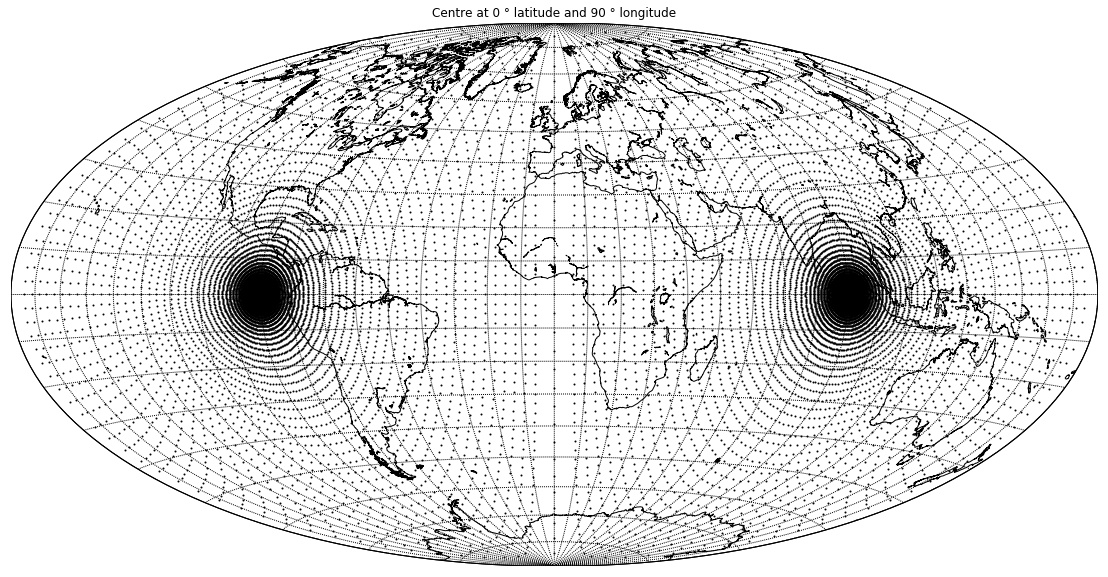

In [13]:
grid = Gauss_Grid(sigma,beta,phi_ini,phi_max,lat_0,lon_0,n,plot=True,Dense_Antipole = True)